# Medical Image VAE Analysis
## Modular Convolutional Variational Autoencoder for Medical Imaging

This notebook implements a clean, modular approach to training and evaluating Variational Autoencoders on medical imaging datasets using the MedMNIST collection. The code follows proper Python conventions and avoids unnecessary abstraction.

## 1. Libraries and Configuration

In [1]:
# Standard library imports
import os
import random
from typing import Tuple, Dict, Any
from pathlib import Path

# Third-party imports
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
from tqdm import tqdm

# MedMNIST imports
import medmnist
from medmnist import INFO, Evaluator

print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/
PyTorch version: 2.5.1+cu121
CUDA available: True


In [2]:
# Configuration constants
CONFIG = {
    'DATA_FLAG': 'pathmnist',  # Can change to 'breastmnist', 'pathmnist', etc.
    'BATCH_SIZE': 128,
    'NUM_EPOCHS': 10,
    'LEARNING_RATE': 1e-3,
    'LATENT_DIM': 128,
    'BETA_KL': 0.1,  # KL divergence weighting
    'KL_ANNEAL_EPOCHS': 0,
    'SEED': 42,
    'SAVE_INTERVAL': 50,  # Save samples every N epochs
    'OUTPUT_DIR': 'outputs'
}

# Set random seeds for reproducibility
def set_seed(seed: int) -> None:
    """Set random seeds for reproducible results."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed(CONFIG['SEED'])

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create output directory
output_dir = Path(CONFIG['OUTPUT_DIR'])
output_dir.mkdir(exist_ok=True)
print(f"Output directory: {output_dir.absolute()}")

Using device: cuda
Output directory: c:\Users\Hanifi\Desktop\Projects\vae-medical-image-generator\outputs


## 2. Data Preparation and Loading

In [3]:
def get_dataset_info(data_flag: str) -> Dict[str, Any]:
    """Get dataset information and configuration."""
    info = INFO[data_flag]
    dataset_info = {
        'task': info['task'],
        'n_channels': info['n_channels'],
        'n_classes': len(info['label']),
        'data_class': getattr(medmnist, info['python_class']),
        'description': info.get('description', 'No description available')
    }
    return dataset_info

def create_data_loaders(data_flag: str, batch_size: int, download: bool = True) -> Tuple[DataLoader, DataLoader]:
    """Create train and test data loaders."""
    # Get dataset information
    dataset_info = get_dataset_info(data_flag)
    DataClass = dataset_info['data_class']
    
    # Define transforms
    transform = transforms.Compose([
        transforms.ToTensor(),
        # Note: MedMNIST images are already normalized to [0, 1]
    ])
    
    # Load datasets
    train_dataset = DataClass(split='train', transform=transform, download=download)
    test_dataset = DataClass(split='test', transform=transform, download=download)
    
    # Create data loaders
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=torch.cuda.is_available()
    )
    
    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=torch.cuda.is_available()
    )
    
    return train_loader, test_loader, dataset_info

# Load data
train_loader, test_loader, dataset_info = create_data_loaders(
    CONFIG['DATA_FLAG'], 
    CONFIG['BATCH_SIZE']
)

print(f"Dataset: {CONFIG['DATA_FLAG']}")
print(f"Task: {dataset_info['task']}")
print(f"Channels: {dataset_info['n_channels']}")
print(f"Classes: {dataset_info['n_classes']}")
print(f"Train samples: {len(train_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")
print(f"Batches per epoch: {len(train_loader)}")

Using downloaded and verified file: C:\Users\Hanifi\.medmnist\pathmnist.npz
Using downloaded and verified file: C:\Users\Hanifi\.medmnist\pathmnist.npz
Dataset: pathmnist
Task: multi-class
Channels: 3
Classes: 9
Train samples: 89996
Test samples: 7180
Batches per epoch: 704
Using downloaded and verified file: C:\Users\Hanifi\.medmnist\pathmnist.npz
Dataset: pathmnist
Task: multi-class
Channels: 3
Classes: 9
Train samples: 89996
Test samples: 7180
Batches per epoch: 704


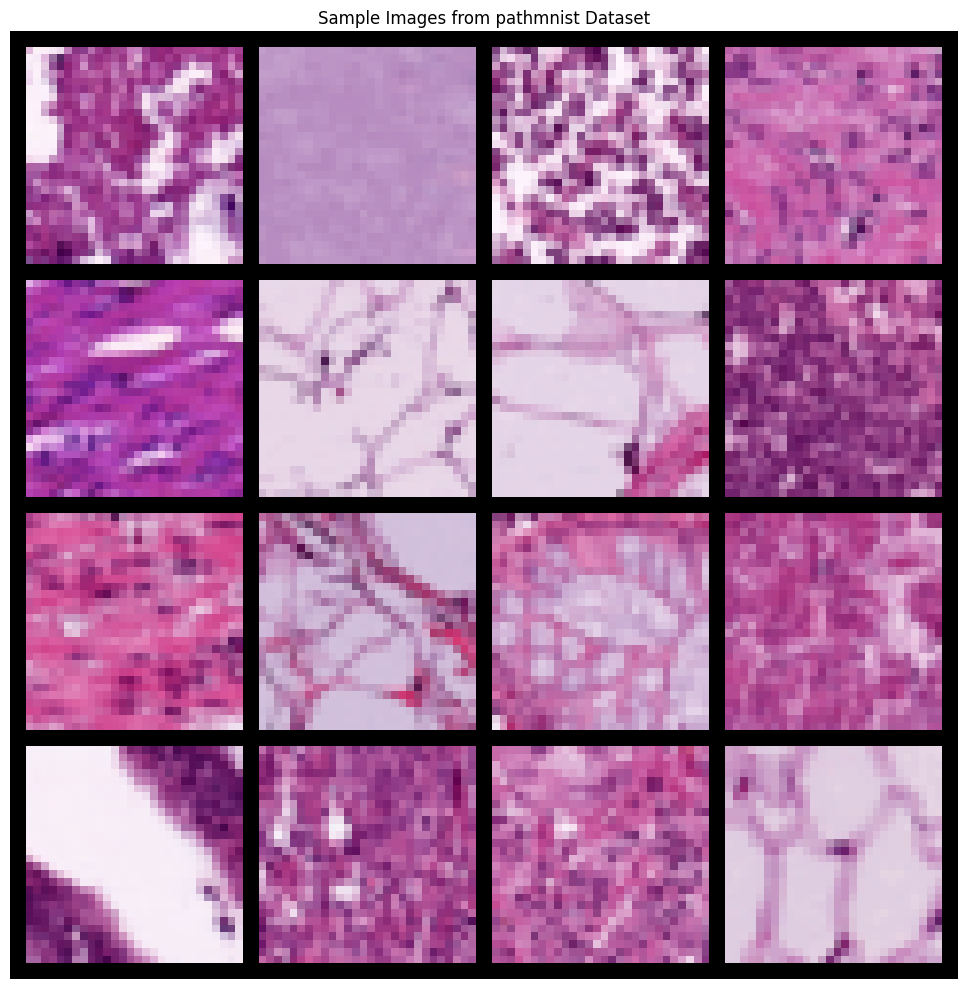

In [4]:
# Visualize sample data
def visualize_samples(data_loader: DataLoader, num_samples: int = 16) -> None:
    """Visualize sample images from the dataset."""
    images, labels = next(iter(data_loader))
    images = images[:num_samples]
    
    # Create grid
    grid = make_grid(images, nrow=4, normalize=True, padding=2)
    
    # Plot
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title(f'Sample Images from {CONFIG["DATA_FLAG"]} Dataset')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_samples(train_loader)

## 3. Model Components: Encoder, Decoder, and VAE

In [5]:
class Encoder(nn.Module):
    """Convolutional encoder for VAE."""
    
    def __init__(self, input_channels: int = 3, latent_dim: int = 128):
        super().__init__()
        self.latent_dim = latent_dim
        
        # Convolutional layers
        self.conv_layers = nn.Sequential(
            # Input: 28x28x3 -> 14x14x32
            nn.Conv2d(input_channels, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            # 14x14x32 -> 7x7x64
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        
        # Calculate flattened size
        self.flatten_size = 7 * 7 * 64
        
        # Dense layers
        self.fc_hidden = nn.Linear(self.flatten_size, 1024)
        self.fc_mu = nn.Linear(1024, latent_dim)
        self.fc_logvar = nn.Linear(1024, latent_dim)
        
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Forward pass through encoder.
        
        Args:
            x: Input tensor of shape (batch_size, channels, height, width)
            
        Returns:
            Tuple of (mu, logvar) for latent distribution
        """
        # Convolutional layers
        x = self.conv_layers(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Dense layers
        x = F.relu(self.fc_hidden(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        
        return mu, logvar

In [6]:
class Decoder(nn.Module):
    """Convolutional decoder for VAE."""
    
    def __init__(self, latent_dim: int = 128, output_channels: int = 3):
        super().__init__()
        self.latent_dim = latent_dim
        
        # Dense layers
        self.fc = nn.Linear(latent_dim, 7 * 7 * 64)
        
        # Transpose convolutional layers
        self.deconv_layers = nn.Sequential(
            # 7x7x64 -> 14x14x64
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            # 14x14x64 -> 28x28x32
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            # 28x28x32 -> 28x28x16
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            # 28x28x16 -> 28x28x output_channels
            nn.ConvTranspose2d(16, output_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()  # Output values in [0, 1]
        )
        
    def forward(self, z: torch.Tensor) -> torch.Tensor:
        """Forward pass through decoder.
        
        Args:
            z: Latent tensor of shape (batch_size, latent_dim)
            
        Returns:
            Reconstructed image tensor
        """
        # Dense layer
        x = F.relu(self.fc(z))
        
        # Reshape for convolution
        x = x.view(x.size(0), 64, 7, 7)
        
        # Transpose convolutional layers
        x = self.deconv_layers(x)
        
        return x

In [ ]:
def sigmoid_annealing(epoch, total_epochs, steepness=0.1):
    progress = epoch / total_epochs
    return CONFIG['BETA_KL'] / (1 + np.exp(-steepness * (progress - 0.5)))

def reparameterize(mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
    """Reparameterization trick for VAE sampling."""
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

def vae_loss(recon_x: torch.Tensor, x: torch.Tensor, mu: torch.Tensor, 
             logvar: torch.Tensor, beta: float = 1.0) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """Calculate VAE loss (reconstruction + KL divergence).
    
    Args:
        recon_x: Reconstructed images
        x: Original images
        mu: Mean of latent distribution
        logvar: Log variance of latent distribution
        beta: KL divergence weighting factor
        
    Returns:
        Tuple of (total_loss, reconstruction_loss, kl_loss)
    """
    # Reconstruction loss (binary cross-entropy)
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    
    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Total loss
    total_loss = recon_loss + beta * kl_loss
    
    return total_loss, recon_loss, kl_loss

class VAE(nn.Module):
    """Variational Autoencoder combining encoder and decoder."""
    
    def __init__(self, input_channels: int = 3, latent_dim: int = 128):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(input_channels, latent_dim)
        self.decoder = Decoder(latent_dim, input_channels)
        
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Forward pass through VAE.
        
        Args:
            x: Input images
            
        Returns:
            Tuple of (reconstructed_images, mu, logvar)
        """
        # Encode
        mu, logvar = self.encoder(x)
        
        # Sample from latent distribution
        z = reparameterize(mu, logvar)
        
        # Decode
        recon_x = self.decoder(z)
        
        return recon_x, mu, logvar
    
    def generate(self, num_samples: int, device: torch.device) -> torch.Tensor:
        """Generate new samples from random latent codes."""
        with torch.no_grad():
            z = torch.randn(num_samples, self.latent_dim, device=device)
            samples = self.decoder(z)
        return samples

In [8]:
# Add functions to track mu and logvar statistics
def track_latent_stats(mu: torch.Tensor, logvar: torch.Tensor) -> Dict[str, float]:
    """Track statistics of mu and logvar during training."""
    with torch.no_grad():
        mu_stats = {
            'mu_mean': mu.mean().item(),
            'mu_std': mu.std().item(),
            'mu_min': mu.min().item(),
            'mu_max': mu.max().item()
        }
        
        logvar_stats = {
            'logvar_mean': logvar.mean().item(),
            'logvar_std': logvar.std().item(),
            'logvar_min': logvar.min().item(),
            'logvar_max': logvar.max().item()
        }
        
        # Also track the actual standard deviation (exp(0.5 * logvar))
        std = torch.exp(0.5 * logvar)
        std_stats = {
            'std_mean': std.mean().item(),
            'std_std': std.std().item(),
            'std_min': std.min().item(),
            'std_max': std.max().item()
        }
        
        return {**mu_stats, **logvar_stats, **std_stats}

def print_latent_stats(stats: Dict[str, float], prefix: str = "") -> None:
    """Print latent statistics in a readable format."""
    print(f"{prefix}Latent Statistics:")
    print(f"  μ: mean={stats['mu_mean']:.4f}, std={stats['mu_std']:.4f}, range=[{stats['mu_min']:.4f}, {stats['mu_max']:.4f}]")
    print(f"  logvar: mean={stats['logvar_mean']:.4f}, std={stats['logvar_std']:.4f}, range=[{stats['logvar_min']:.4f}, {stats['logvar_max']:.4f}]")
    print(f"  σ: mean={stats['std_mean']:.4f}, std={stats['std_std']:.4f}, range=[{stats['std_min']:.4f}, {stats['std_max']:.4f}]")

In [9]:
# Function to check if parameters are changing
def check_parameter_changes(model: VAE, old_params: Dict[str, torch.Tensor]) -> Dict[str, float]:
    """Check if model parameters have changed."""
    changes = {}
    
    for name, param in model.named_parameters():
        if name in old_params:
            old_param = old_params[name]
            param_diff = torch.norm(param - old_param).item()
            param_norm = torch.norm(param).item()
            relative_change = param_diff / (param_norm + 1e-8)
            changes[name] = relative_change
            
            # Focus on encoder mu and logvar layers
            if 'fc_mu' in name or 'fc_logvar' in name:
                print(f"  {name}: diff={param_diff:.6f}, rel_change={relative_change:.6f}")
    
    return changes

def store_parameters(model: VAE) -> Dict[str, torch.Tensor]:
    """Store current model parameters."""
    return {name: param.clone().detach() for name, param in model.named_parameters()}

In [10]:
# Initialize model
model = VAE(
    input_channels=dataset_info['n_channels'],
    latent_dim=CONFIG['LATENT_DIM']
).to(device)

# Initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=CONFIG['LEARNING_RATE'])

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model initialized with {total_params:,} total parameters")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: {total_params * 4 / 1024 / 1024:.2f} MB (float32)")

Model initialized with 3,959,459 total parameters
Trainable parameters: 3,959,459
Model size: 15.10 MB (float32)


In [11]:
# Debug: Check encoder output before training
print("=== PRE-TRAINING ENCODER DEBUG ===")
model.eval()
with torch.no_grad():
    # Get a single batch
    test_data, _ = next(iter(train_loader))
    test_data = test_data[:32].to(device)  # Use smaller batch for debugging
    
    print(f"Input shape: {test_data.shape}")
    print(f"Input range: [{test_data.min():.4f}, {test_data.max():.4f}]")
    
    # Forward pass through encoder
    mu, logvar = model.encoder(test_data)
    
    print(f"Encoder output shapes: mu={mu.shape}, logvar={logvar.shape}")
    
    # Check if encoder is producing meaningful outputs
    initial_stats = track_latent_stats(mu, logvar)
    print_latent_stats(initial_stats, "Initial ")
    
    # Check if the encoder weights are reasonable
    print(f"Encoder fc_mu weight range: [{model.encoder.fc_mu.weight.min():.4f}, {model.encoder.fc_mu.weight.max():.4f}]")
    print(f"Encoder fc_logvar weight range: [{model.encoder.fc_logvar.weight.min():.4f}, {model.encoder.fc_logvar.weight.max():.4f}]")
    
    # Check if mu and logvar are getting gradients
    mu_requires_grad = any(p.requires_grad for p in model.encoder.fc_mu.parameters())
    logvar_requires_grad = any(p.requires_grad for p in model.encoder.fc_logvar.parameters())
    print(f"Mu layer requires grad: {mu_requires_grad}")
    print(f"Logvar layer requires grad: {logvar_requires_grad}")

model.train()
print("=== END PRE-TRAINING DEBUG ===\n")

=== PRE-TRAINING ENCODER DEBUG ===
Input shape: torch.Size([32, 3, 28, 28])
Input range: [0.1373, 0.9765]
Input shape: torch.Size([32, 3, 28, 28])
Input range: [0.1373, 0.9765]
Encoder output shapes: mu=torch.Size([32, 128]), logvar=torch.Size([32, 128])
Initial Latent Statistics:
  μ: mean=0.0005, std=0.0210, range=[-0.0509, 0.0760]
  logvar: mean=0.0026, std=0.0206, range=[-0.0490, 0.0557]
  σ: mean=1.0014, std=0.0103, range=[0.9758, 1.0283]
Encoder fc_mu weight range: [-0.0312, 0.0312]
Encoder fc_logvar weight range: [-0.0312, 0.0312]
Mu layer requires grad: True
Logvar layer requires grad: True
=== END PRE-TRAINING DEBUG ===

Encoder output shapes: mu=torch.Size([32, 128]), logvar=torch.Size([32, 128])
Initial Latent Statistics:
  μ: mean=0.0005, std=0.0210, range=[-0.0509, 0.0760]
  logvar: mean=0.0026, std=0.0206, range=[-0.0490, 0.0557]
  σ: mean=1.0014, std=0.0103, range=[0.9758, 1.0283]
Encoder fc_mu weight range: [-0.0312, 0.0312]
Encoder fc_logvar weight range: [-0.0312, 0.0

## 4. Training Loop

In [12]:
def train_epoch(model: VAE, train_loader: DataLoader, optimizer: optim.Optimizer,
                device: torch.device, beta: float) -> Dict[str, float]:
    """Train model for one epoch."""
    model.train()
    total_loss = 0.0
    total_recon_loss = 0.0
    total_kl_loss = 0.0
    num_batches = len(train_loader)
    
    # Track latent statistics
    all_mu = []
    all_logvar = []
    
    with tqdm(train_loader, desc="Training", leave=False) as pbar:
        for batch_idx, (data, _) in enumerate(pbar):
            data = data.to(device)
            
            # Forward pass
            recon_batch, mu, logvar = model(data)
            
            # Store mu and logvar for first few batches
            if batch_idx < 5:  # Track first 5 batches
                all_mu.append(mu.detach().cpu())
                all_logvar.append(logvar.detach().cpu())
            
            # Calculate loss
            loss, recon_loss, kl_loss = vae_loss(recon_batch, data, mu, logvar, beta)
            
            # Normalize by batch size
            loss = loss / data.size(0)
            recon_loss = recon_loss / data.size(0)
            kl_loss = kl_loss / data.size(0)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Accumulate losses
            total_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_kl_loss += kl_loss.item()
            
            # Update progress bar
            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Recon': f'{recon_loss.item():.4f}',
                'KL': f'{kl_loss.item():.4f}'
            })
    
    # Calculate and return latent statistics
    if all_mu:
        combined_mu = torch.cat(all_mu, dim=0)
        combined_logvar = torch.cat(all_logvar, dim=0)
        latent_stats = track_latent_stats(combined_mu, combined_logvar)
    else:
        latent_stats = {}
    
    return {
        'total_loss': total_loss / num_batches,
        'recon_loss': total_recon_loss / num_batches,
        'kl_loss': total_kl_loss / num_batches,
        'latent_stats': latent_stats
    }

def evaluate_model(model: VAE, test_loader: DataLoader, 
                  device: torch.device, beta: float) -> Dict[str, float]:
    """Evaluate model on test set."""
    model.eval()
    total_loss = 0.0
    total_recon_loss = 0.0
    total_kl_loss = 0.0
    num_batches = len(test_loader)
    
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            
            # Forward pass
            recon_batch, mu, logvar = model(data)
            
            # Calculate loss
            loss, recon_loss, kl_loss = vae_loss(recon_batch, data, mu, logvar, beta)
            
            # Normalize by batch size
            loss = loss / data.size(0)
            recon_loss = recon_loss / data.size(0)
            kl_loss = kl_loss / data.size(0)
            
            # Accumulate losses
            total_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_kl_loss += kl_loss.item()
    
    return {
        'total_loss': total_loss / num_batches,
        'recon_loss': total_recon_loss / num_batches,
        'kl_loss': total_kl_loss / num_batches
    }

In [13]:
# Training loop
train_losses = []
test_losses = []

print("Starting training...")
print(f"Total epochs: {CONFIG['NUM_EPOCHS']}")
print(f"KL annealing over {CONFIG['KL_ANNEAL_EPOCHS']} epochs")

# Store initial parameters
initial_params = store_parameters(model)

for epoch in range(CONFIG['NUM_EPOCHS']):
    # Store parameters before training
    if epoch == 0:
        pre_epoch_params = store_parameters(model)
    
    # Calculate beta for KL annealing
    if CONFIG['KL_ANNEAL_EPOCHS'] > 0:
        beta = min(1.0, epoch / CONFIG['KL_ANNEAL_EPOCHS'])
    else:
        beta = sigmoid_annealing(epoch, CONFIG['NUM_EPOCHS'] * 5)  # Very gradual
    
    # Train for one epoch
    train_metrics = train_epoch(model, train_loader, optimizer, device, beta)
    
    # Evaluate on test set
    test_metrics = evaluate_model(model, test_loader, device, beta)
    
    # Store losses
    train_losses.append(train_metrics)
    test_losses.append(test_metrics)
    
    # Print epoch summary
    print(f"Epoch [{epoch+1}/{CONFIG['NUM_EPOCHS']}] β={beta:.3f}")
    print(f"  Train - Loss: {train_metrics['total_loss']:.4f}, "
          f"Recon: {train_metrics['recon_loss']:.4f}, "
          f"KL: {train_metrics['kl_loss']:.4f}")
    print(f"  Test  - Loss: {test_metrics['total_loss']:.4f}, "
          f"Recon: {test_metrics['recon_loss']:.4f}, "
          f"KL: {test_metrics['kl_loss']:.4f}")
    
    # Print latent statistics
    if 'latent_stats' in train_metrics and train_metrics['latent_stats']:
        print_latent_stats(train_metrics['latent_stats'], "  Train ")
    
    # Add gradient norm checking
    total_grad_norm = 0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_grad_norm += param_norm.item() ** 2
    total_grad_norm = total_grad_norm ** (1. / 2)
    print(f"  Gradient norm: {total_grad_norm:.4f}")
    
    # Check parameter changes for first few epochs
    if epoch < 3:
        print("  Parameter changes (encoder mu/logvar layers):")
        check_parameter_changes(model, pre_epoch_params)
        pre_epoch_params = store_parameters(model)
    
    print()  # Empty line for better readability
    
    # Save samples periodically
    if (epoch + 1) % CONFIG['SAVE_INTERVAL'] == 0:
        with torch.no_grad():
            # Generate new samples
            samples = model.generate(16, device)
            save_image(samples, output_dir / f'generated_epoch_{epoch+1}.png', 
                      nrow=4, normalize=True)
            
            # Reconstruct test images
            test_data, _ = next(iter(test_loader))
            test_data = test_data[:16].to(device)
            recon_data, _, _ = model(test_data)
            
            # Save comparison
            comparison = torch.cat([test_data, recon_data])
            save_image(comparison, output_dir / f'reconstruction_epoch_{epoch+1}.png',
                      nrow=8, normalize=True)
        
        print(f"  Saved samples to {output_dir}")

print("Training completed!")

Starting training...
Total epochs: 10
KL annealing over 0 epochs


Epoch [1/10] β=0.100
  Train - Loss: 23.6943, Recon: 21.9325, KL: 17.6178
  Test  - Loss: 24.6973, Recon: 22.4373, KL: 22.5991
  Train Latent Statistics:
  μ: mean=0.0090, std=0.4638, range=[-2.8496, 2.9837]
  logvar: mean=-0.0271, std=0.3055, range=[-1.7094, 2.1019]
  σ: mean=0.9985, std=0.1619, range=[0.4254, 2.8603]
  Gradient norm: 55.2153
  Parameter changes (encoder mu/logvar layers):
  encoder.fc_mu.weight: diff=2.375637, rel_change=0.348029
  encoder.fc_mu.bias: diff=0.127764, rel_change=0.583122
  encoder.fc_logvar.weight: diff=2.437108, rel_change=0.361756
  encoder.fc_logvar.bias: diff=0.208687, rel_change=0.710662



Epoch [2/10] β=0.100
  Train - Loss: 18.7680, Recon: 16.6997, KL: 20.6828
  Test  - Loss: 22.8895, Recon: 20.3363, KL: 25.5328
  Train Latent Statistics:
  μ: mean=-0.0095, std=0.4000, range=[-6.1919, 6.3096]
  logvar: mean=-0.3027, std=0.7050, range=[-5.4186, 0.3936]
  σ: mean=0.8955, std=0.1761, range=[0.0666, 1.2175]
  Gradient norm: 70.6073
  Parameter changes (encoder mu/logvar layers):
  encoder.fc_mu.weight: diff=1.343173, rel_change=0.194849
  encoder.fc_mu.bias: diff=0.032078, rel_change=0.147705
  encoder.fc_logvar.weight: diff=0.864385, rel_change=0.128187
  encoder.fc_logvar.bias: diff=0.099029, rel_change=0.286918



Epoch [3/10] β=0.100
  Train - Loss: 17.9686, Recon: 15.7313, KL: 22.3737
  Test  - Loss: 20.9473, Recon: 17.8994, KL: 30.4799
  Train Latent Statistics:
  μ: mean=-0.0089, std=0.4085, range=[-5.9138, 6.7089]
  logvar: mean=-0.3663, std=0.7629, range=[-5.9487, 0.2494]
  σ: mean=0.8747, std=0.1942, range=[0.0511, 1.1328]
  Gradient norm: 247.8807
  Parameter changes (encoder mu/logvar layers):
  encoder.fc_mu.weight: diff=1.193969, rel_change=0.170523
  encoder.fc_mu.bias: diff=0.085007, rel_change=0.357037
  encoder.fc_logvar.weight: diff=0.576227, rel_change=0.085618
  encoder.fc_logvar.bias: diff=0.078281, rel_change=0.203213



Epoch [4/10] β=0.100
  Train - Loss: 17.3563, Recon: 15.0353, KL: 23.2106
  Test  - Loss: 19.7214, Recon: 16.6926, KL: 30.2876
  Train Latent Statistics:
  μ: mean=0.0025, std=0.4395, range=[-6.3557, 7.0788]
  logvar: mean=-0.3554, std=0.8613, range=[-7.4836, 0.4374]
  σ: mean=0.8889, std=0.2127, range=[0.0237, 1.2444]
  Gradient norm: 218.5804



Epoch [5/10] β=0.100
  Train - Loss: 16.9082, Recon: 14.5397, KL: 23.6848
  Test  - Loss: 19.1788, Recon: 15.9667, KL: 32.1216
  Train Latent Statistics:
  μ: mean=0.0134, std=0.4309, range=[-5.6453, 4.8542]
  logvar: mean=-0.3617, std=0.7721, range=[-6.3599, 0.4204]
  σ: mean=0.8784, std=0.2054, range=[0.0416, 1.2339]
  Gradient norm: 33.4487



Epoch [6/10] β=0.100
  Train - Loss: 16.5977, Recon: 14.2088, KL: 23.8890
  Test  - Loss: 19.6392, Recon: 16.3819, KL: 32.5734
  Train Latent Statistics:
  μ: mean=0.0058, std=0.4459, range=[-9.4778, 5.7752]
  logvar: mean=-0.3253, std=0.8031, range=[-7.4809, 0.4584]
  σ: mean=0.8973, std=0.2157, range=[0.0237, 1.2576]
  Gradient norm: 118.5729



Epoch [7/10] β=0.100
  Train - Loss: 16.4448, Recon: 14.0224, KL: 24.2238
  Test  - Loss: 18.5623, Recon: 15.3359, KL: 32.2645
  Train Latent Statistics:
  μ: mean=0.0213, std=0.4364, range=[-5.0752, 6.5632]
  logvar: mean=-0.3993, std=0.7715, range=[-6.7176, 0.2741]
  σ: mean=0.8615, std=0.2022, range=[0.0348, 1.1469]
  Gradient norm: 62.7987



Epoch [8/10] β=0.100
  Train - Loss: 16.3070, Recon: 13.8649, KL: 24.4217
  Test  - Loss: 18.9909, Recon: 15.5196, KL: 34.7126
  Train Latent Statistics:
  μ: mean=0.0050, std=0.4333, range=[-5.8626, 6.7879]
  logvar: mean=-0.3778, std=0.7745, range=[-7.5471, 0.3242]
  σ: mean=0.8715, std=0.2066, range=[0.0230, 1.1759]
  Gradient norm: 140.5837



Epoch [9/10] β=0.100
  Train - Loss: 16.1748, Recon: 13.6975, KL: 24.7729
  Test  - Loss: 20.6097, Recon: 17.2797, KL: 33.3001
  Train Latent Statistics:
  μ: mean=0.0000, std=0.4422, range=[-7.0467, 6.1794]
  logvar: mean=-0.3909, std=0.8042, range=[-7.8541, 0.3419]
  σ: mean=0.8693, std=0.2153, range=[0.0197, 1.1864]
  Gradient norm: 162.2618



Epoch [10/10] β=0.100
  Train - Loss: 16.0799, Recon: 13.5907, KL: 24.8918
  Test  - Loss: 17.9991, Recon: 14.6780, KL: 33.2111
  Train Latent Statistics:
  μ: mean=0.0042, std=0.4535, range=[-5.4822, 6.5496]
  logvar: mean=-0.3511, std=0.8215, range=[-7.7319, 0.3183]
  σ: mean=0.8881, std=0.2203, range=[0.0209, 1.1725]
  Gradient norm: 47.4881

Training completed!


## 5. Evaluation and Visualization

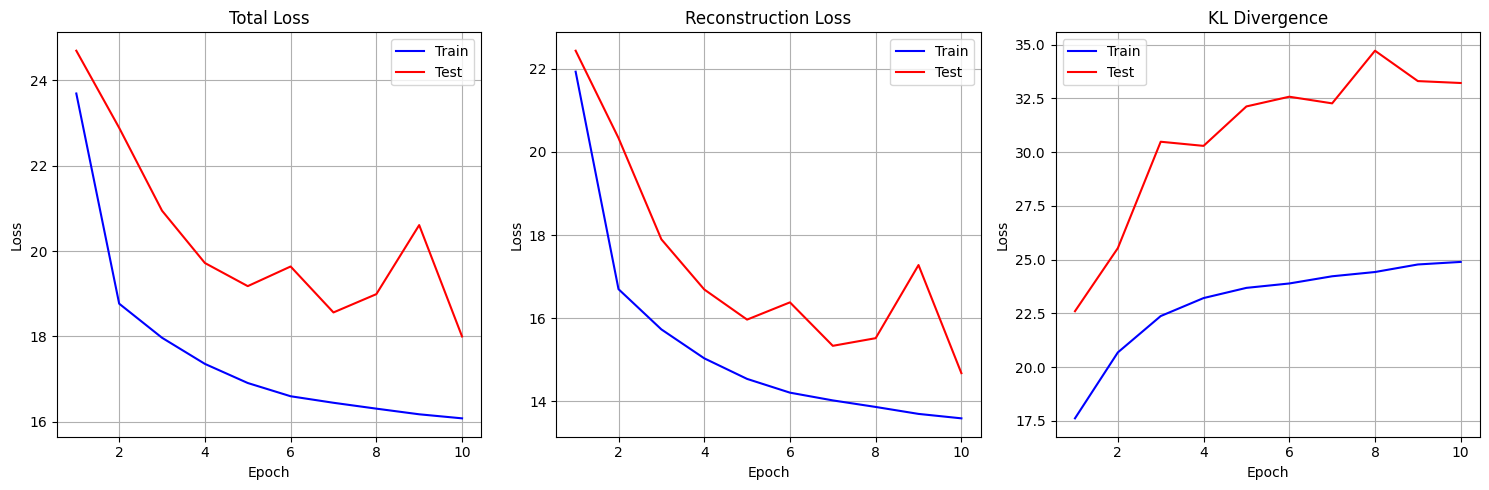

In [14]:
# Plot training curves
def plot_training_curves(train_losses: list, test_losses: list) -> None:
    """Plot training and test loss curves."""
    epochs = range(1, len(train_losses) + 1)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Total loss
    axes[0].plot(epochs, [m['total_loss'] for m in train_losses], 'b-', label='Train')
    axes[0].plot(epochs, [m['total_loss'] for m in test_losses], 'r-', label='Test')
    axes[0].set_title('Total Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # Reconstruction loss
    axes[1].plot(epochs, [m['recon_loss'] for m in train_losses], 'b-', label='Train')
    axes[1].plot(epochs, [m['recon_loss'] for m in test_losses], 'r-', label='Test')
    axes[1].set_title('Reconstruction Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)
    
    # KL divergence
    axes[2].plot(epochs, [m['kl_loss'] for m in train_losses], 'b-', label='Train')
    axes[2].plot(epochs, [m['kl_loss'] for m in test_losses], 'r-', label='Test')
    axes[2].set_title('KL Divergence')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Loss')
    axes[2].legend()
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot the curves
plot_training_curves(train_losses, test_losses)

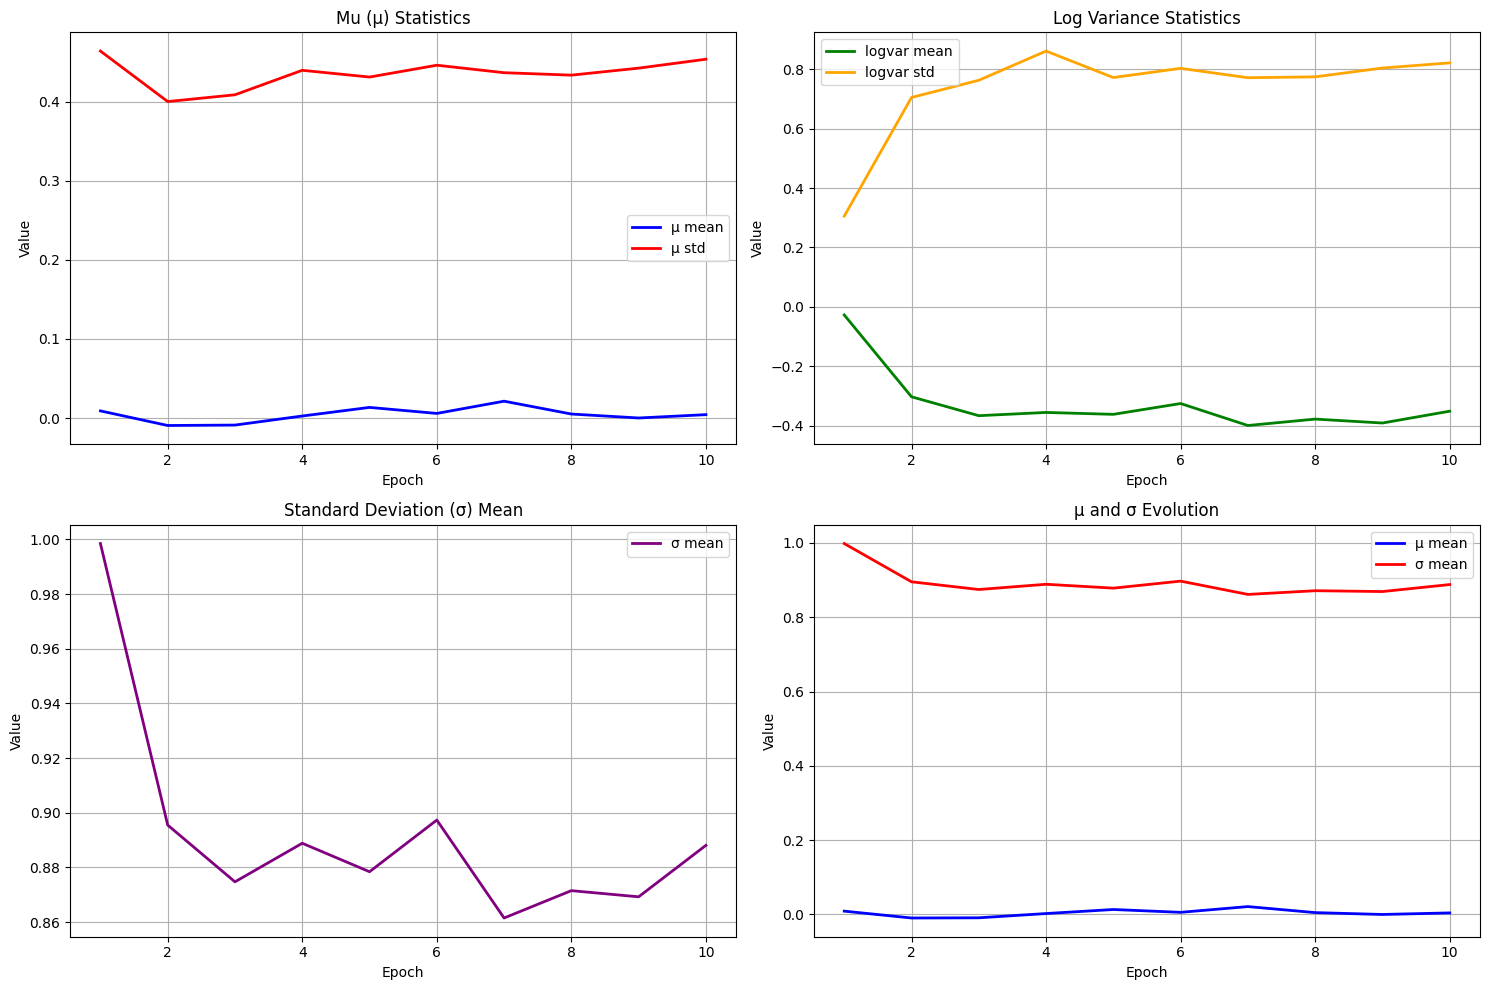

In [15]:
# Plot latent statistics over time
def plot_latent_evolution(train_losses: list) -> None:
    """Plot how latent statistics evolve during training."""
    # Extract latent statistics
    epochs = []
    mu_means = []
    mu_stds = []
    logvar_means = []
    logvar_stds = []
    std_means = []
    
    for i, loss_dict in enumerate(train_losses):
        if 'latent_stats' in loss_dict and loss_dict['latent_stats']:
            stats = loss_dict['latent_stats']
            epochs.append(i + 1)
            mu_means.append(stats['mu_mean'])
            mu_stds.append(stats['mu_std'])
            logvar_means.append(stats['logvar_mean'])
            logvar_stds.append(stats['logvar_std'])
            std_means.append(stats['std_mean'])
    
    if not epochs:
        print("No latent statistics to plot")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Mu statistics
    axes[0, 0].plot(epochs, mu_means, 'b-', label='μ mean', linewidth=2)
    axes[0, 0].plot(epochs, mu_stds, 'r-', label='μ std', linewidth=2)
    axes[0, 0].set_title('Mu (μ) Statistics')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Value')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Logvar statistics
    axes[0, 1].plot(epochs, logvar_means, 'g-', label='logvar mean', linewidth=2)
    axes[0, 1].plot(epochs, logvar_stds, 'orange', label='logvar std', linewidth=2)
    axes[0, 1].set_title('Log Variance Statistics')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Value')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Standard deviation (exp(0.5 * logvar))
    axes[1, 0].plot(epochs, std_means, 'purple', label='σ mean', linewidth=2)
    axes[1, 0].set_title('Standard Deviation (σ) Mean')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Value')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Combined view
    axes[1, 1].plot(epochs, mu_means, 'b-', label='μ mean', linewidth=2)
    axes[1, 1].plot(epochs, std_means, 'r-', label='σ mean', linewidth=2)
    axes[1, 1].set_title('μ and σ Evolution')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Value')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot latent evolution if we have the data
if train_losses:
    plot_latent_evolution(train_losses)

Reconstruction comparison:


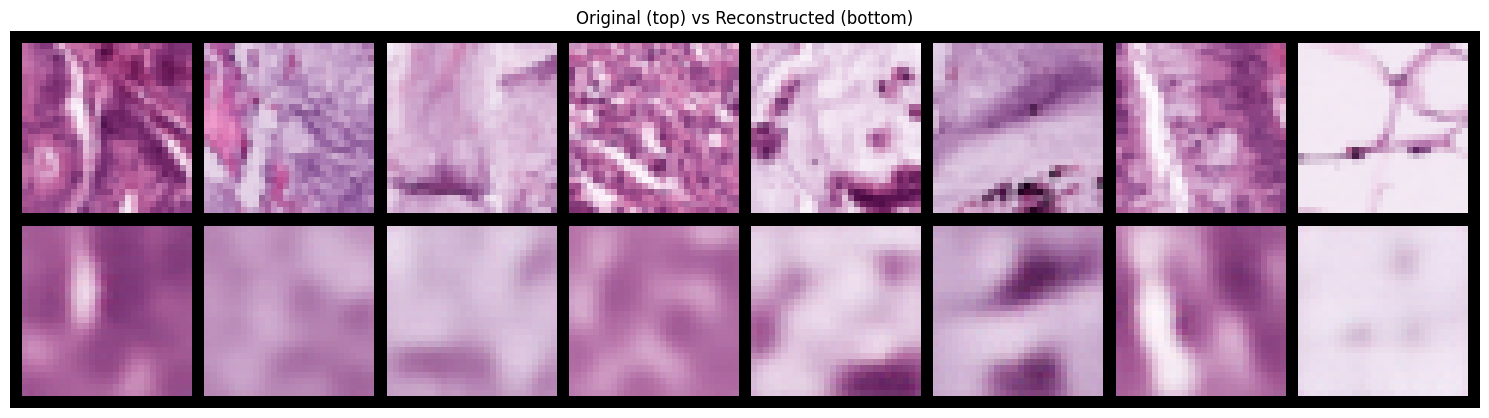


Generated samples:


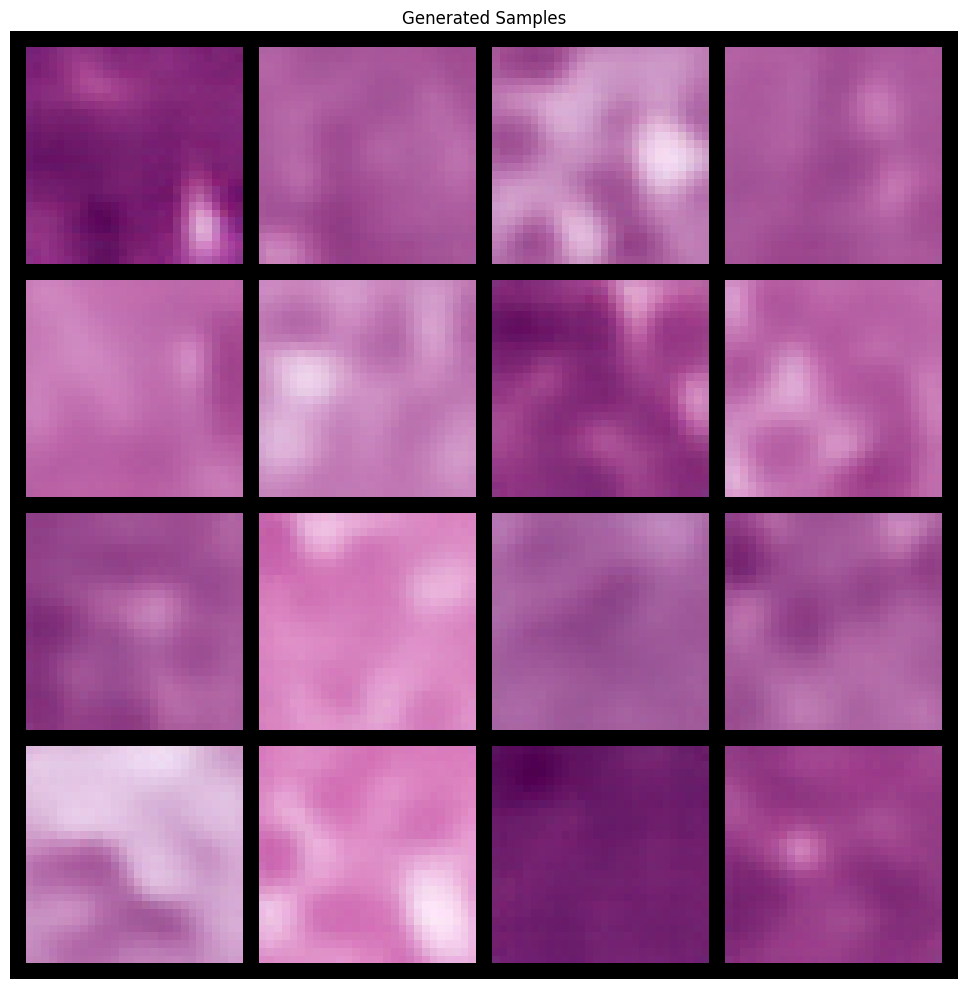


Latent space interpolation:


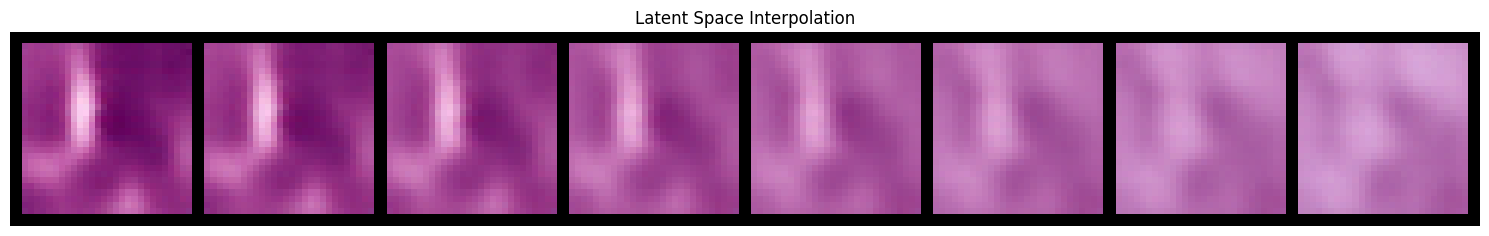

In [16]:
# Visualization functions
def show_reconstruction_comparison(model: VAE, test_loader: DataLoader, 
                                 device: torch.device, num_samples: int = 8) -> None:
    """Show original vs reconstructed images side by side."""
    model.eval()
    
    with torch.no_grad():
        # Get test batch
        test_data, _ = next(iter(test_loader))
        test_data = test_data[:num_samples].to(device)
        
        # Reconstruct
        recon_data, _, _ = model(test_data)
        
        # Create comparison
        comparison = torch.cat([test_data, recon_data])
        grid = make_grid(comparison, nrow=num_samples, normalize=True, padding=2)
        
        # Plot
        plt.figure(figsize=(15, 6))
        plt.imshow(grid.permute(1, 2, 0).cpu())
        plt.title('Original (top) vs Reconstructed (bottom)')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

def show_generated_samples(model: VAE, device: torch.device, num_samples: int = 16) -> None:
    """Show generated samples from random latent codes."""
    model.eval()
    
    with torch.no_grad():
        # Generate samples
        samples = model.generate(num_samples, device)
        grid = make_grid(samples, nrow=4, normalize=True, padding=2)
        
        # Plot
        plt.figure(figsize=(10, 10))
        plt.imshow(grid.permute(1, 2, 0).cpu())
        plt.title('Generated Samples')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

def interpolate_latent_space(model: VAE, test_loader: DataLoader, 
                           device: torch.device, num_steps: int = 8) -> None:
    """Interpolate between two images in latent space."""
    model.eval()
    
    with torch.no_grad():
        # Get two test images
        test_data, _ = next(iter(test_loader))
        img1, img2 = test_data[:2].to(device)
        
        # Encode to latent space
        mu1, _ = model.encoder(img1.unsqueeze(0))
        mu2, _ = model.encoder(img2.unsqueeze(0))
        
        # Interpolate
        interpolations = []
        for i in range(num_steps):
            alpha = i / (num_steps - 1)
            z_interp = (1 - alpha) * mu1 + alpha * mu2
            recon = model.decoder(z_interp)
            interpolations.append(recon)
        
        # Create grid
        interpolation_tensor = torch.cat(interpolations)
        grid = make_grid(interpolation_tensor, nrow=num_steps, normalize=True, padding=2)
        
        # Plot
        plt.figure(figsize=(15, 4))
        plt.imshow(grid.permute(1, 2, 0).cpu())
        plt.title('Latent Space Interpolation')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

# Show visualizations
print("Reconstruction comparison:")
show_reconstruction_comparison(model, test_loader, device)

print("\nGenerated samples:")
show_generated_samples(model, device)

print("\nLatent space interpolation:")
interpolate_latent_space(model, test_loader, device)

In [17]:
# Save the trained model
model_path = output_dir / 'vae_model.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'config': CONFIG,
    'dataset_info': dataset_info,
    'train_losses': train_losses,
    'test_losses': test_losses
}, model_path)

print(f"Model saved to: {model_path}")
print(f"Final train loss: {train_losses[-1]['total_loss']:.4f}")
print(f"Final test loss: {test_losses[-1]['total_loss']:.4f}")

Model saved to: outputs\vae_model.pth
Final train loss: 16.0799
Final test loss: 17.9991
